In [1]:
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, linspace, exp, real, imag, abs, conj
from numpy.fft import fft, fftshift

In [2]:
%matplotlib inline

In [3]:
b=.08*1e-3

a=.25*1e-3

k=2*pi/(795*1e-9)

wt=0

C=1

L=1.9

d=.03

In [4]:
def alpha(y):
    return k*a*y/(2*L)

In [5]:
def beta(y):
    return k*b*y/(2*L)

In [6]:
def E(y):
    return b*C*(sin(beta(y)) / beta(y)) * (sin(wt-k*L) + sin(wt-k*L+2*alpha(y)))

In [7]:
def E_lo(y):
    return C*exp(1j*k*d*y/L)

## b=.08 and a=.25

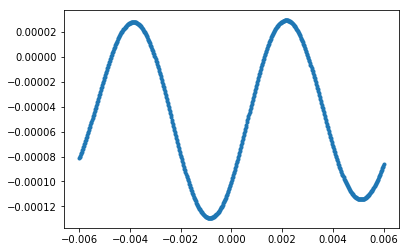

In [8]:
y = linspace(-.006,.006,600)

plt.plot(y,E(y),".-")

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


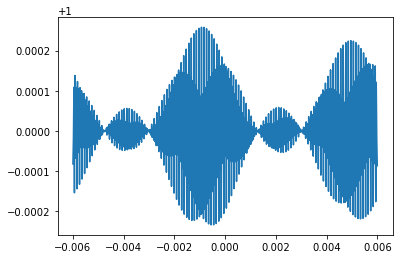

In [9]:

TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(200, 250)

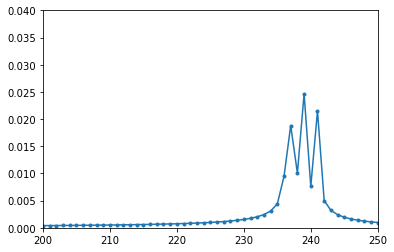

In [10]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.04])

plt.xlim([200,250])


## d=0.035

In [11]:
d=0.035

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


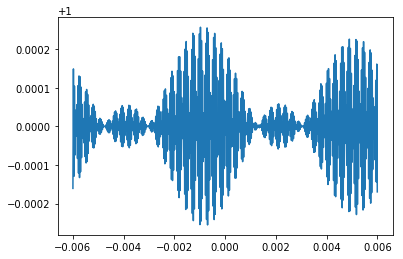

In [12]:

TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(250, 300)

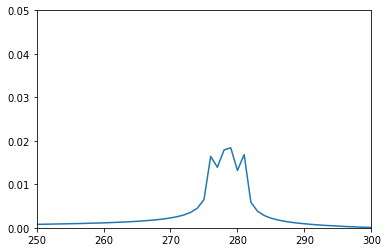

In [13]:
plt.plot(abs(fft(TotalIntensity)))

plt.ylim([0,.05])
plt.xlim([250,300])

## d=0.02

In [14]:
d=0.02

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


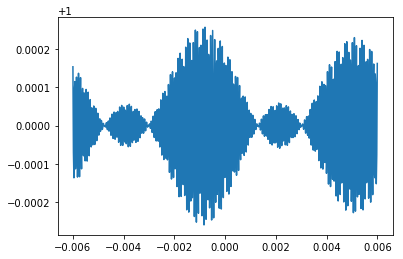

In [15]:

TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(150, 200)

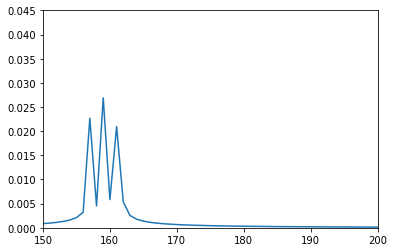

In [16]:
plt.plot(abs(fft(TotalIntensity)))

plt.ylim([0,.045])
plt.xlim([150,200])

## b=.08, a=.5 d=.03

In [17]:
b=.08*1e-3

a=.5*1e-3

d=.03

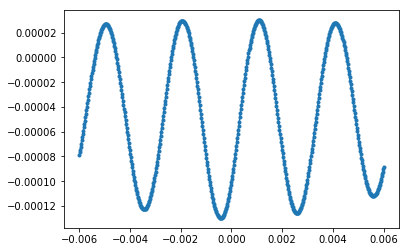

In [18]:
plt.plot(y,E(y),".-")

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


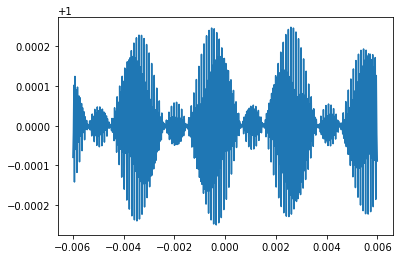

In [19]:
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(200, 250)

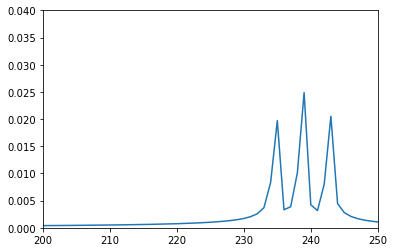

In [20]:
plt.plot(abs(fft(TotalIntensity)))

plt.ylim([0,.04])
plt.xlim([200,250])

d=.01

In [21]:
d=.01

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


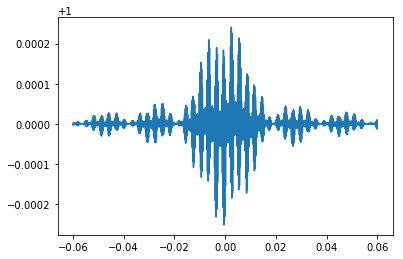

In [58]:
y = linspace(-.06,.06,1200)
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(0, 0.05)

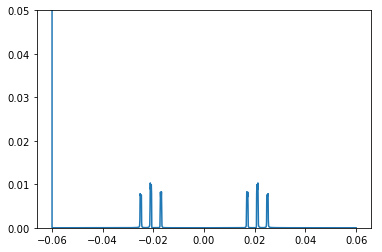

In [59]:
plt.plot(y,abs(fft(TotalIntensity)))

plt.ylim([0,.05])

d=.02

In [60]:
d=.02

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


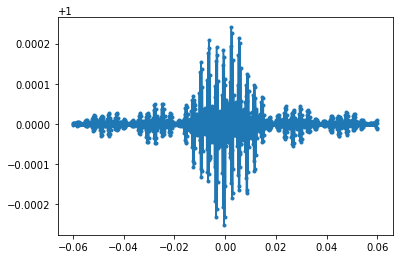

In [61]:

TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity,".-")
#plt.xlim([-.002,0])

(0, 0.08)

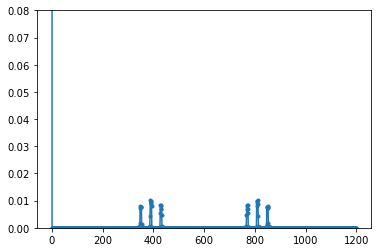

In [62]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.08])

#plt.xlim([125,175])

### Now, import gaussian beam function, and repeat:

In [63]:
import BeamOptics as bopt

In [109]:
d=.02

In [121]:
E_lo_gauss = bopt.gaussian_beam(0,y,L+0.5,E0=0.005,zR=1.35,w0=0.00135,k=[0,k*d/L,k])

#TODO: check these beam parameters for sanity

#TODO: k value make sense?

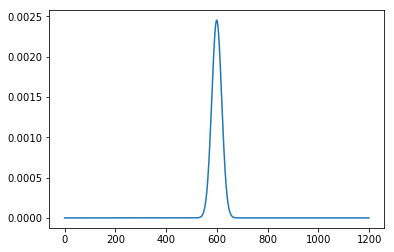

In [122]:
plt.plot(abs(E_lo_gauss))

In [123]:
TotalIntensity=(E(y)+E_lo_gauss) * (E(y)+E_lo_gauss).conj()

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


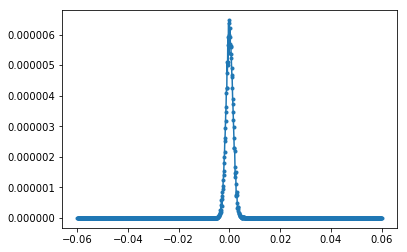

In [124]:
plt.plot(y,TotalIntensity,".-")
#plt.xlim([-.002,0])

(0, 1e-05)

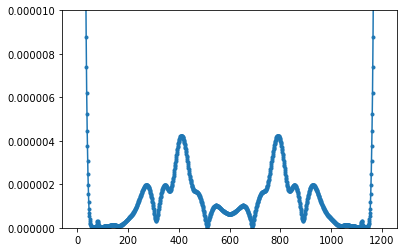

In [125]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.00001]) # Had to lower the LO power quite a bit, and then zoom way in.

#plt.xlim([0,300])

## Conclusions:
It definitely widens the peaks... but also makes more of them. Not sure why. Need to sort that out.